In [1048]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import tensorflow as tf
import os
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from imblearn.metrics import sensitivity_specificity_support
#from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
from prettytable import PrettyTable
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge
import tensorflow as tf
from tensorflow.keras import Sequential,layers,Input,optimizers,callbacks,losses,models
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as k
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
plt.rcParams["figure.figsize"] = (20,7)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
sns.set_style("darkgrid")
import pickle
import warnings
warnings.filterwarnings("ignore")

- Approach 1: (Posing it as Time Series Forecasting)
    - Data Preparation is based on taking lags of past 24 hours and prepare the data to fit in Stacked LSTM Model
    - During Forecasting on Test Data we need to take past 24 hours data from Validation set and need to forecast 
      the car demand for first record Test Data and once we forecast for second record, past 24 hours records includes 
    the first data from Test Record. This process continues untill last record reached.
    
- Approach 2: (Posing it as regression Problem)
    - Data Preparation based on different features like, day of week, is weekend, month, year. One-Hot-Encoding on Month, year and hour.
    - DNN Model with Drop-out layer used to train the model
    - Forecasted the car demand data based on model trained.

**Approach - 2 has shown better RMSE score, so proceed with the DNN Model from approach 2 for private score Evaluation**

## Approach - 1 - Posing it as Forecasting/Time Series Problem¶

In [1049]:
Filepath = r'D:\Samarjit\Analytic Vidya\Job-a-thon\Data\train_E1GspfA.csv'
train_df = pd.read_csv(Filepath,parse_dates=['date'])
print(train_df.shape)

print(train_df.date.min(),train_df.date.max())

train_df.head()

(18247, 3)
2018-08-18 00:00:00 2021-02-28 00:00:00


date  hour  demand
0 2018-08-18     9      91
1 2018-08-18    10      21
2 2018-08-18    13      23
3 2018-08-18    14     104
4 2018-08-18    15      81

In [1050]:
features_considered = ['hour', 'demand']

features = train_df[features_considered]
features.index = train_df['date']
features.head()

hour  demand
date                    
2018-08-18     9      91
2018-08-18    10      21
2018-08-18    13      23
2018-08-18    14     104
2018-08-18    15      81

### Statistical testing

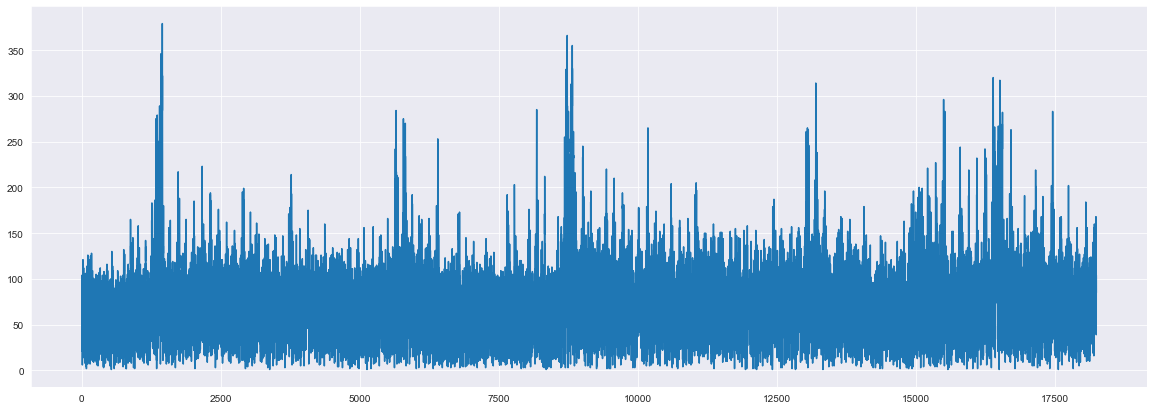

In [1051]:
train_df.demand.plot()
plt.show()

In [1052]:
#Is the data stationary?
#Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(train_df.demand)
print("pvalue = ", pvalue, " if above 0.05, data is not stationary")
#Since data is not stationary, we may need SARIMA and not just ARIMA

pvalue =  2.2857754622026913e-23  if above 0.05, data is not stationary


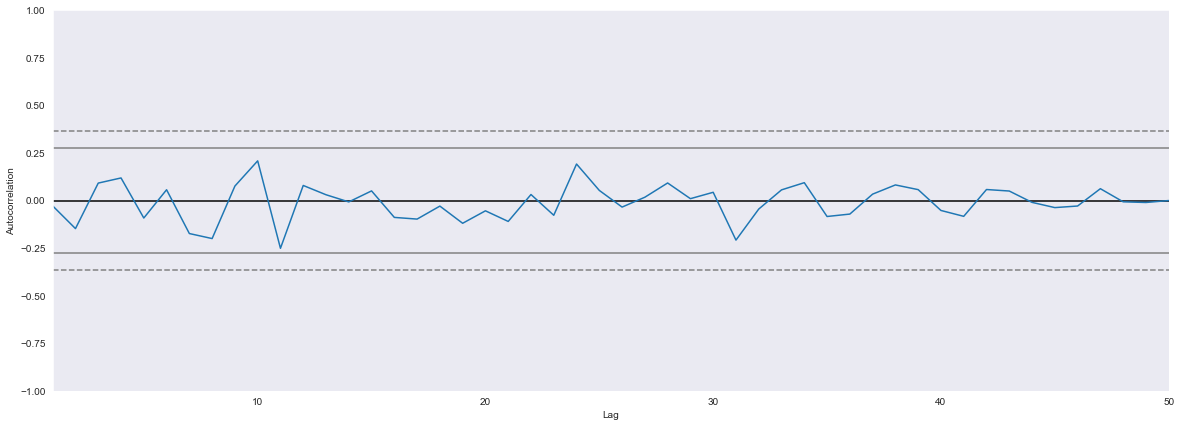

In [1053]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(train_df['demand'][0:50], )
plt.show()
#Horizontal bands indicate 95% and 99% (dashed) confidence bands

#A strong positive correlation for lags below 40 (months)

In [1054]:
TRAIN_SPLIT=16942
dataset = features

### Encoding Numerical Features

In [1055]:
scaler1=MinMaxScaler()

#dataset = train_df
scaler1.fit_transform(dataset['demand'].iloc[:TRAIN_SPLIT].values.reshape(-1, 1))
dataset['demand']= scaler1.transform(dataset['demand'].values.reshape(-1, 1))

scaler2=MinMaxScaler()
scaler2.fit(dataset['hour'].iloc[:TRAIN_SPLIT].values.reshape(-1, 1))
dataset['hour'] = scaler2.transform(dataset['hour'].values.reshape(-1, 1))

In [1056]:
dataset.head()

hour    demand
date                          
2018-08-18  0.391304  0.238095
2018-08-18  0.434783  0.052910
2018-08-18  0.565217  0.058201
2018-08-18  0.608696  0.272487
2018-08-18  0.652174  0.211640

In [1057]:
dataset.shape

(18247, 2)

### Creating Data with Lag of past 24 hours & predict the current timestamp car demand w.r.t previous 24 hours data

In [1058]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step) # step used here.
    data.append(dataset.iloc[indices])

    if single_step: # single_step used here.
      labels.append(target[i+target_size]) 
    else:
      labels.append(target[i:i+target_size]) 

  return np.array(data), np.array(labels)

In [1059]:
past_history = 24 # 24*7
future_target = 0 # next Timestep Predict
STEP = 1 # one obs every 6X10min = 60 min => 1 hr

x_train_single, y_train_single = multivariate_data(dataset, dataset['demand'], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset['demand'],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

print(x_train_single.shape)
print(y_train_single.shape)
print(x_val_single.shape)
print(y_val_single.shape)

(16918, 24, 2)
(16918,)
(1281, 24, 2)
(1281,)


### Data Preparation - Convert Numpy Data to Tensors

In [1060]:
BATCH_SIZE = 256 # bacth size in batch-SGD/variants
BUFFER_SIZE = 10000 # for shuffling the dataset

In [1061]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

print(train_data_single)
print(val_data_single)

<RepeatDataset element_spec=(TensorSpec(shape=(None, 24, 2), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<RepeatDataset element_spec=(TensorSpec(shape=(None, 24, 2), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [1062]:
STEPS_PER_EPOCH = 200
EPOCHS = 20

### Model Training - LSTM

In [1063]:
single_step_model = tf.keras.models.Sequential()

single_step_model.add(tf.keras.layers.LSTM(16,return_sequences=True,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.LSTM(8,
                                           input_shape=x_train_single.shape[-2:]))
'''single_step_model.add(Dense(16,activation = 'relu', kernel_initializer="he_normal"))
single_step_model.add(Dropout(0.3))
single_step_model.add(Dense(8,activation = 'relu', kernel_initializer="he_normal"))
single_step_model.add(Dropout(0.3))'''
single_step_model.add(Dense(1,activation = 'linear'))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse')

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=STEPS_PER_EPOCH,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/20
200/200 [==============================] - 9s 27ms/step - loss: 0.0103 - val_loss: 0.0081
Epoch 2/20
200/200 [==============================] - 4s 22ms/step - loss: 0.0083 - val_loss: 0.0077
Epoch 3/20
200/200 [==============================] - 4s 22ms/step - loss: 0.0080 - val_loss: 0.0078
Epoch 4/20
200/200 [==============================] - 5s 24ms/step - loss: 0.0079 - val_loss: 0.0076
Epoch 5/20
200/200 [==============================] - 4s 21ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 6/20
200/200 [==============================] - 4s 21ms/step - loss: 0.0077 - val_loss: 0.0080
Epoch 7/20
200/200 [==============================] - 4s 21ms/step - loss: 0.0077 - val_loss: 0.0078
Epoch 8/20
200/200 [==============================] - 4s 21ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 9/20
200/200 [==============================] - 4s 21ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 10/20
200/200 [==============================] - 4s 21ms/step - loss: 0.0076 - val_lo

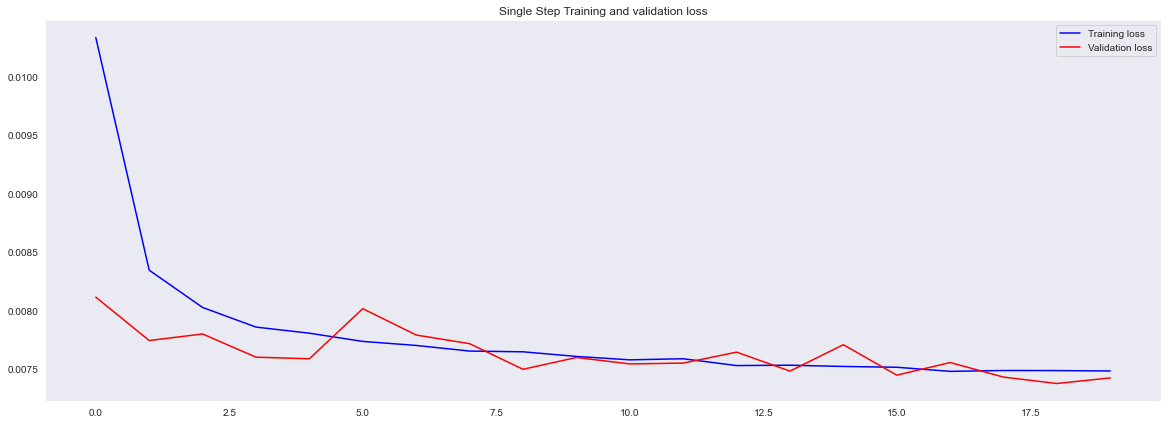

In [1064]:
# Plot train and validation loss over epochs

def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()
  plt.grid()

  plt.show()



plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

In [1065]:
def datadisplay(df):
  x= PrettyTable()
  x.field_names = df.columns
  for index, row in df.iterrows():
    x.add_row(row)
  return x

### Model Evaluation

In [1066]:
##Making predictions for train and test sets: linear Regression Model
y_train_pred_scaled = single_step_model.predict(x_train_single)
                                            
y_val_pred_scaled= single_step_model.predict(x_val_single)

y_train_single_actual=scaler1.inverse_transform(y_train_single.reshape(-1, 1))
y_val_single_actual=scaler1.inverse_transform(y_val_single.reshape(-1, 1))

y_train_pred=scaler1.inverse_transform(y_train_pred_scaled).astype(int)
y_val_pred=scaler1.inverse_transform(y_val_pred_scaled).astype(int)

print(y_val_pred,y_val_single_actual)

##R2 score for linear Regression Model
r2_score_train = r2_score(y_train_single_actual,y_train_pred)
r2_score_test = r2_score(y_val_single_actual,y_val_pred)

##Check the mean squared error (MSE) for linear Regression Model
MSE_train = mean_squared_error(y_train_single_actual,y_train_pred)
MSE_test = mean_squared_error(y_val_single_actual,y_val_pred)

MAPE_train = mean_absolute_percentage_error(y_train_single_actual,y_train_pred)
MAPE_test = mean_absolute_percentage_error(y_val_single_actual,y_val_pred)

##Mean Absolute error for train and test sets
MAE_train = mean_absolute_error(y_train_single_actual,y_train_pred)
MAE_test = mean_absolute_error(y_val_single_actual,y_val_pred)

##Root Mean Squared Error for Train and Test Sets
RMSE_train = np.sqrt(MSE_train)
RMSE_test = np.sqrt(MSE_test)

df_score_linear=pd.DataFrame({'score':['r2_score','MSE','MAPE','MAE','RMSE'],
                       'Train_linear':[round(r2_score_train,4),round(MSE_train,4),round(MAPE_train,4),round(MAE_train,4),round(RMSE_train,4)],
                       'Test_linear':[round(r2_score_test,4),round(MSE_test,4),round(MAPE_test,4),round(MAE_test,4),round(RMSE_test,4)]
                        })
print('The model evaluation')
print(datadisplay(df_score_linear))

[[57]
 [59]
 [58]
 ...
 [82]
 [70]
 [68]] [[ 90.]
 [ 33.]
 [ 88.]
 ...
 [ 39.]
 [104.]
 [ 85.]]
The model evaluation
+----------+--------------+-------------+
|  score   | Train_linear | Test_linear |
+----------+--------------+-------------+
| r2_score |    0.3976    |    0.2865   |
|   MSE    |  1057.6445   |  1057.4044  |
|   MAPE   |    0.8375    |     0.7     |
|   MAE    |   27.2016    |   27.3263   |
|   RMSE   |   32.5214    |   32.5178   |
+----------+--------------+-------------+


### Evaluation on Test Data - Future Unseen Data (Forecasting Car Demand for next 1yr)

In [1067]:
Filepath = r'D:\Samarjit\Analytic Vidya\Job-a-thon\Data\test_6QvDdzb.csv'
test_df = pd.read_csv(Filepath,parse_dates=['date'])
test_df.head()

date  hour
0 2021-03-01     0
1 2021-03-01     1
2 2021-03-01     2
3 2021-03-01     3
4 2021-03-01     5

In [1068]:
test_df.shape

(7650, 2)

In [1069]:
features_considered = ['hour']

features = test_df[features_considered]
features.index = test_df['date']
features.head()

hour
date            
2021-03-01     0
2021-03-01     1
2021-03-01     2
2021-03-01     3
2021-03-01     5

#### Scaling Numerical Feature

In [1070]:
features['hour'] = scaler2.transform(features['hour'].values.reshape(-1, 1))

In [1071]:
features.head()

hour
date                
2021-03-01  0.000000
2021-03-01  0.043478
2021-03-01  0.086957
2021-03-01  0.130435
2021-03-01  0.217391

In [1072]:
features.shape

(7650, 1)

### Data Preparation

In [1073]:
x_input_to_test_data = x_val_single[-1:]

In [1078]:
x_input_to_test_data.shape

(1, 24, 2)

In [1075]:
temp_input=list(x_input_to_test_data)
temp_input=temp_input[0].tolist()

In [1076]:
len(temp_input)

24

In [1077]:
x_input_to_test_data.shape

(1, 24, 2)

### Future Forecasting

In [1079]:
from numpy import array

lst_output=[]
n_steps=24
i=0
while(i<features.shape[0]):
    
    if(len(temp_input)>n_steps):
        l = []
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print(x_input.shape)
        print("{} day input {}".format(i,x_input))
        #x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 2))
        #print(x_input)
        yhat = single_step_model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat[0][0]))
        #temp_input.extend(yhat[0].tolist())
        l.extend([features['hour'].iloc[i],yhat[0][0]])
        temp_input.append(l)
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        l = []
        #x_input = x_input.reshape((1, n_steps ,1))
        yhat = single_step_model.predict(x_input_to_test_data, verbose=0)
        #print(yhat[0][0])
        #temp_input = temp_input[1:]
        l.extend([features['hour'].iloc[i],yhat[0][0]])
        temp_input.append(l)
        #print(len(temp_input))
        lst_output.append(yhat[0][0])
        i += 1
    

print(lst_output)

1 day input [[0.         0.28306878]
 [0.04347826 0.10582011]
 [0.08695652 0.28571429]
 [0.13043478 0.14550265]
 [0.17391304 0.17195767]
 [0.2173913  0.15873016]
 [0.26086957 0.21164021]
 [0.30434783 0.23280423]
 [0.34782609 0.18783069]
 [0.39130435 0.3042328 ]
 [0.43478261 0.20634921]
 [0.47826087 0.20634921]
 [0.52173913 0.31216931]
 [0.56521739 0.37830688]
 [0.60869565 0.26455026]
 [0.65217391 0.22751323]
 [0.69565217 0.44179894]
 [0.73913043 0.25661376]
 [0.7826087  0.32010582]
 [0.82608696 0.24867725]
 [0.86956522 0.23015873]
 [0.91304348 0.1005291 ]
 [0.95652174 0.27248677]
 [0.         0.17809451]]
1 day output 0.15461137890815735
2 day input [[0.04347826 0.10582011]
 [0.08695652 0.28571429]
 [0.13043478 0.14550265]
 [0.17391304 0.17195767]
 [0.2173913  0.15873016]
 [0.26086957 0.21164021]
 [0.30434783 0.23280423]
 [0.34782609 0.18783069]
 [0.39130435 0.3042328 ]
 [0.43478261 0.20634921]
 [0.47826087 0.20634921]
 [0.52173913 0.31216931]
 [0.56521739 0.37830688]
 [0.60869565 0.26

### Inverse Scaling on Predicted Data

In [1080]:
lst_output_actual = scaler1.inverse_transform(np.array(lst_output).reshape(-1,1)).astype(int)

In [1081]:
lst_output_actual[:3]

array([[68],
       [59],
       [57]])

### Merging Forecasted value in Submission File

In [1082]:
Filepath = r'D:\Samarjit\Analytic Vidya\Job-a-thon\Data\sample_4E0BhPN.csv'
sub_df = pd.read_csv(Filepath,parse_dates=['date'])
sub_df.head()

date  hour  demand
0 2021-03-01     0       0
1 2021-03-01     1       0
2 2021-03-01     2       0
3 2021-03-01     3       0
4 2021-03-01     5       0

In [1083]:
sub_df.demand = lst_output_actual

In [1084]:
sub_df.head()

date  hour  demand
0 2021-03-01     0      68
1 2021-03-01     1      59
2 2021-03-01     2      57
3 2021-03-01     3      56
4 2021-03-01     5      55

In [1047]:
sub_df.to_csv('D:\Samarjit\Analytic Vidya\Job-a-thon\Data\sample_submission_2.csv',index=False)

- Best RMSE Score(On Future Data) - 36.0102420665666

## Approach - 2 - Posing it as Regression Problem

In [1003]:
Filepath = r'D:\Samarjit\Analytic Vidya\Job-a-thon\Data\train_E1GspfA.csv'
train_df = pd.read_csv(Filepath,parse_dates=['date'])
train_df.head()

date  hour  demand
0 2018-08-18     9      91
1 2018-08-18    10      21
2 2018-08-18    13      23
3 2018-08-18    14     104
4 2018-08-18    15      81

In [1004]:
train_df.shape

(18247, 3)

In [922]:
train_df.hour.min(),train_df.hour.max()

(0, 23)

In [925]:
train_df.demand.min(),train_df.demand.max()

(1, 379)

In [923]:
train_df.date.min(),train_df.date.max()

(Timestamp('2018-08-18 00:00:00'), Timestamp('2021-02-28 00:00:00'))

In [924]:
train_df.date.min(),train_df.date.max()

(Timestamp('2018-08-18 00:00:00'), Timestamp('2021-02-28 00:00:00'))

### Feature Engineering & Data Preparation

Creating Day, month, year & weekday feature

In [926]:
train_df['day'] = train_df.date.dt.day
train_df['month'] = train_df.date.dt.month
train_df['year'] = train_df.date.dt.year
train_df['weekday'] = train_df.date.dt.weekday

In [927]:
train_df['is_weekend'] = train_df.weekday.apply(lambda x: 'Yes' if x in [5,6] else 'No')

In [928]:
train_df.head()

date  hour  demand  day  month  year  weekday is_weekend
0 2018-08-18     9      91   18      8  2018        5        Yes
1 2018-08-18    10      21   18      8  2018        5        Yes
2 2018-08-18    13      23   18      8  2018        5        Yes
3 2018-08-18    14     104   18      8  2018        5        Yes
4 2018-08-18    15      81   18      8  2018        5        Yes

In [930]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18247 entries, 0 to 18246
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        18247 non-null  datetime64[ns]
 1   hour        18247 non-null  int64         
 2   demand      18247 non-null  int64         
 3   day         18247 non-null  int64         
 4   month       18247 non-null  int64         
 5   year        18247 non-null  int64         
 6   weekday     18247 non-null  int64         
 7   is_weekend  18247 non-null  object        
dtypes: datetime64[ns](1), int64(6), object(1)
memory usage: 1.1+ MB


### EDA - Finding Demand Pattern Weekly/Hourly

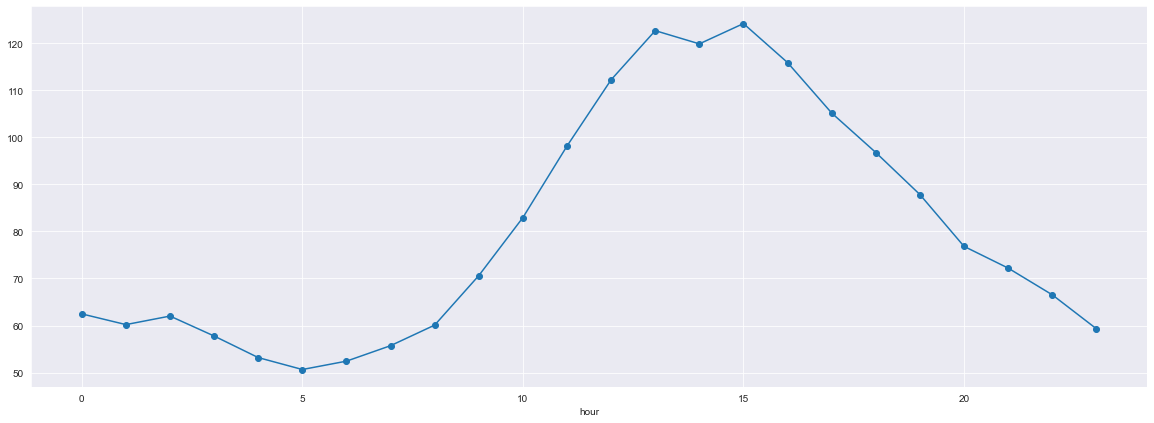

In [931]:
train_df[train_df.is_weekend == 'Yes'].groupby('hour').demand.mean().plot(marker = 'o')
plt.show()

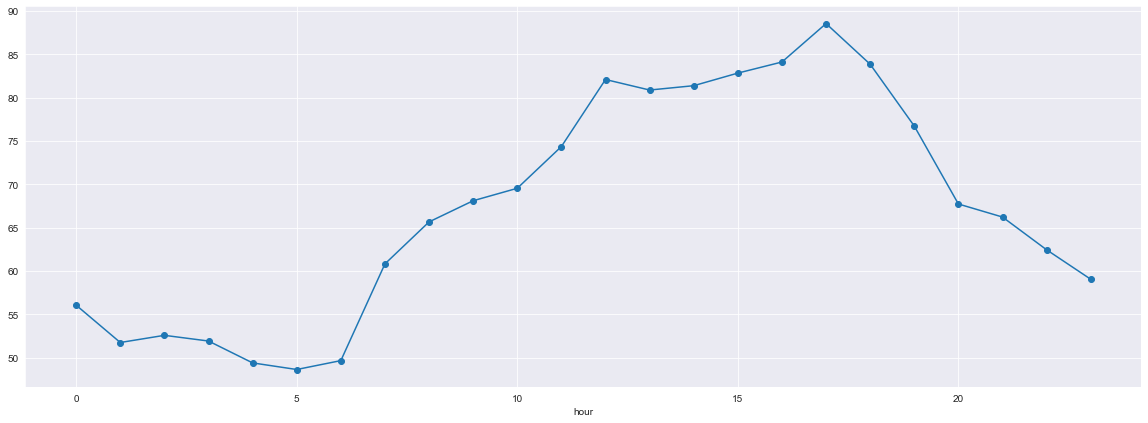

In [932]:
train_df[train_df.is_weekend == 'No'].groupby('hour').demand.mean().plot(marker = 'o')
plt.show()

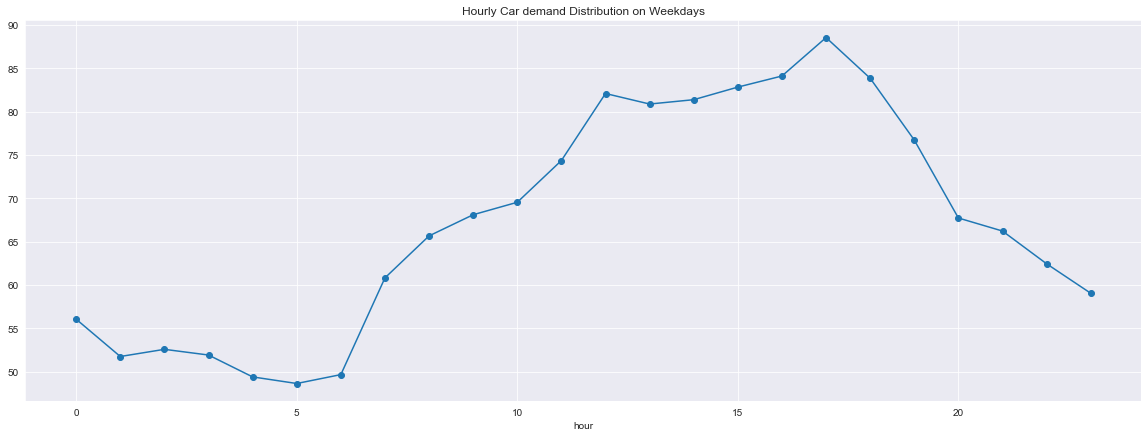

In [933]:
train_df[train_df.is_weekend == 'No'].groupby('hour').demand.mean().plot(marker = 'o')
plt.title('Hourly Car demand Distribution on Weekdays')
plt.show()

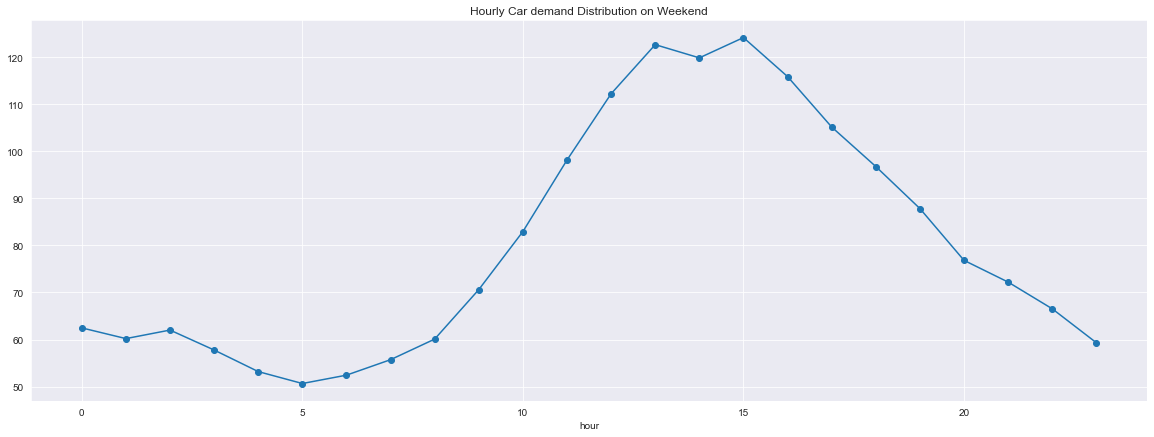

In [934]:
train_df[train_df.is_weekend == 'Yes'].groupby('hour').demand.mean().plot(marker = 'o')
plt.title('Hourly Car demand Distribution on Weekend')
plt.show()

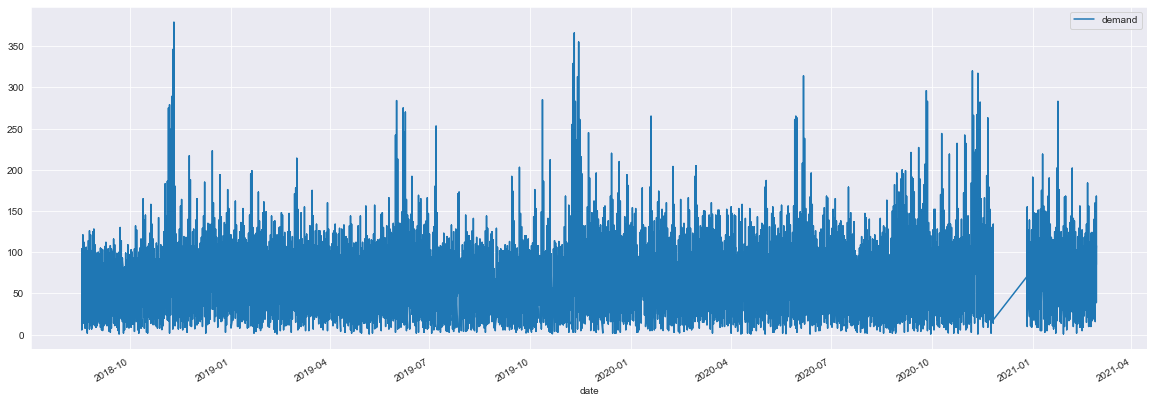

In [935]:
sub = train_df[['date','demand']]
sub.set_index('date',inplace=True)
sub.plot(kind = 'line')
plt.show()

In [936]:
#Is the data stationary?
#Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(sub.demand)
print("pvalue = ", pvalue, " if above 0.05, data is not stationary")
#Since data is not stationary, we may need SARIMA and not just ARIMA

pvalue =  2.2857754622026913e-23  if above 0.05, data is not stationary


It suggests the data is stationary

### Feature Engineering

In [937]:
train_df.shape

(18247, 8)

In [938]:
train_df.drop(columns = 'date',inplace=True)

In [939]:
train_df.head()

hour  demand  day  month  year  weekday is_weekend
0     9      91   18      8  2018        5        Yes
1    10      21   18      8  2018        5        Yes
2    13      23   18      8  2018        5        Yes
3    14     104   18      8  2018        5        Yes
4    15      81   18      8  2018        5        Yes

In [940]:
train_df.is_weekend = train_df.is_weekend.apply(lambda x: 1 if x == 'Yes' else 0)

### Encoding year and Month

In [941]:
def convertmonth(x):
  month = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December']
  monthnum = range(1,13,1)
  monthdict = dict()
  for v1,v2 in zip(monthnum,month):
    monthdict[v1] = v2
  
  return monthdict[x]

In [942]:
train_df.month = train_df.month.apply(lambda x: convertmonth(x))

In [943]:
train_df.year = train_df.year.apply(lambda x: str(x))
train_df.day = train_df.day.apply(lambda x: 'day_' + str(x))

In [944]:
train_df.head()

hour  demand     day   month  year  weekday  is_weekend
0     9      91  day_18  August  2018        5           1
1    10      21  day_18  August  2018        5           1
2    13      23  day_18  August  2018        5           1
3    14     104  day_18  August  2018        5           1
4    15      81  day_18  August  2018        5           1

In [945]:
train_df.demand = train_df.demand.astype('float32')

In [946]:
train_df.shape

(18247, 7)

In [947]:
train_df.head()

hour  demand     day   month  year  weekday  is_weekend
0     9    91.0  day_18  August  2018        5           1
1    10    21.0  day_18  August  2018        5           1
2    13    23.0  day_18  August  2018        5           1
3    14   104.0  day_18  August  2018        5           1
4    15    81.0  day_18  August  2018        5           1

In [948]:
train_df = pd.get_dummies(train_df, \
                columns=['hour','weekday','is_weekend'])
train_df.head()

demand     day   month  year  hour_0  hour_1  hour_2  hour_3  hour_4  \
0    91.0  day_18  August  2018       0       0       0       0       0   
1    21.0  day_18  August  2018       0       0       0       0       0   
2    23.0  day_18  August  2018       0       0       0       0       0   
3   104.0  day_18  August  2018       0       0       0       0       0   
4    81.0  day_18  August  2018       0       0       0       0       0   

   hour_5  hour_6  hour_7  hour_8  hour_9  hour_10  hour_11  hour_12  hour_13  \
0       0       0       0       0       1        0        0        0        0   
1       0       0       0       0       0        1        0        0        0   
2       0       0       0       0       0        0        0        0        1   
3       0       0       0       0       0        0        0        0        0   
4       0       0       0       0       0        0        0        0        0   

   hour_14  hour_15  hour_16  hour_17  hour_18  hour_19  hour_20  hour_21  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        1        0        0        0        0        0        0        0   
4        0        1        0        0        0        0        0        0   

   hour_22  hour_23  weekday_0  weekday_1  weekday_2  weekday_3  weekday_4  \
0        0        0          0          0          0          0          0   
1        0        0          0          0          0          0          0   
2        0        0          0          0          0          0          0   
3        0        0          0          0          0          0          0   
4        0        0          0          0          0          0          0   

   weekday_5  weekday_6  is_weekend_0  is_weekend_1  
0          1          0             0             1  
1          1          0             0             1  
2          1          0             0             1  
3          1          0             0             1  
4          1          0             0             1

In [949]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18247 entries, 0 to 18246
Data columns (total 37 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   demand        18247 non-null  float32
 1   day           18247 non-null  object 
 2   month         18247 non-null  object 
 3   year          18247 non-null  object 
 4   hour_0        18247 non-null  uint8  
 5   hour_1        18247 non-null  uint8  
 6   hour_2        18247 non-null  uint8  
 7   hour_3        18247 non-null  uint8  
 8   hour_4        18247 non-null  uint8  
 9   hour_5        18247 non-null  uint8  
 10  hour_6        18247 non-null  uint8  
 11  hour_7        18247 non-null  uint8  
 12  hour_8        18247 non-null  uint8  
 13  hour_9        18247 non-null  uint8  
 14  hour_10       18247 non-null  uint8  
 15  hour_11       18247 non-null  uint8  
 16  hour_12       18247 non-null  uint8  
 17  hour_13       18247 non-null  uint8  
 18  hour_14       18247 non-nu

### Train-Test Split

In [950]:
from sklearn.model_selection import train_test_split

### Random-split

In [951]:
train,test = train_test_split(train_df,train_size=0.8, test_size = 0.2, random_state=100)

In [952]:
train.shape,test.shape

((14597, 37), (3650, 37))

In [953]:
train,val = train_test_split(train,train_size=0.8, test_size = 0.2, random_state=100)

In [954]:
train.shape,val.shape

((11677, 37), (2920, 37))

In [955]:
y_train=train['demand']
X_train=train.drop(['demand'],axis=1)

In [956]:
y_test=test['demand']
X_test=test.drop(['demand'],axis=1)

In [957]:
y_val=val['demand']
X_val=val.drop(['demand'],axis=1)

In [958]:
print('Train set Shape: {} {}'.format(X_train.shape,y_train.shape))
print('Validation set Shape: {} {}'.format(X_val.shape,y_val.shape))
print('Test set Shape: {} {}'.format(X_test.shape,y_test.shape))

Train set Shape: (11677, 36) (11677,)
Validation set Shape: (2920, 36) (2920,)
Test set Shape: (3650, 36) (3650,)


# Train Data Preparation

### Test Data Preparation

In [959]:
train.shape,test.shape

((11677, 37), (3650, 37))

In [960]:
test.reset_index(drop = 'index',inplace=True)
test.head()

demand     day     month  year  hour_0  hour_1  hour_2  hour_3  hour_4  \
0    30.0   day_2   October  2020       0       0       0       0       0   
1    49.0  day_11  November  2018       0       0       0       0       0   
2    20.0  day_21       May  2019       0       0       0       0       0   
3   131.0   day_8  November  2019       0       0       0       0       0   
4    91.0  day_26       May  2019       0       0       0       0       0   

   hour_5  hour_6  hour_7  hour_8  hour_9  hour_10  hour_11  hour_12  hour_13  \
0       0       0       0       0       0        0        0        0        0   
1       0       0       0       0       0        0        0        0        0   
2       1       0       0       0       0        0        0        0        0   
3       0       0       0       0       0        0        0        0        0   
4       0       0       0       0       0        0        0        0        0   

   hour_14  hour_15  hour_16  hour_17  hour_18  hour_19  hour_20  hour_21  \
0        0        0        1        0        0        0        0        0   
1        0        0        0        0        0        0        1        0   
2        0        0        0        0        0        0        0        0   
3        0        1        0        0        0        0        0        0   
4        0        0        0        0        0        0        1        0   

   hour_22  hour_23  weekday_0  weekday_1  weekday_2  weekday_3  weekday_4  \
0        0        0          0          0          0          0          1   
1        0        0          0          0          0          0          0   
2        0        0          0          1          0          0          0   
3        0        0          0          0          0          0          1   
4        0        0          0          0          0          0          0   

   weekday_5  weekday_6  is_weekend_0  is_weekend_1  
0          0          0             1             0  
1          0          1             0             1  
2          0          0             1             0  
3          0          0             1             0  
4          0          1             0             1

### Encoding Features

In [961]:
from sklearn.feature_extraction.text import CountVectorizer
CountVectorizer1 = CountVectorizer()
X_train_year_bow = CountVectorizer1.fit_transform(X_train.year.values)
X_val_year_bow = CountVectorizer1.transform(X_val.year.values)
X_test_year_bow = CountVectorizer1.transform(X_test.year.values)

CountVectorizer2 = CountVectorizer()
X_train_month_bow = CountVectorizer2.fit_transform(X_train.month.values)
X_val_month_bow = CountVectorizer2.transform(X_val.month.values)
X_test_month_bow = CountVectorizer2.transform(X_test.month.values)

CountVectorizer3 = CountVectorizer()
X_train_day_bow = CountVectorizer3.fit_transform(X_train.day.values)
X_val_day_bow = CountVectorizer3.transform(X_val.day.values)
X_test_day_bow = CountVectorizer3.transform(X_test.day.values)

print(X_train_year_bow.shape,X_val_year_bow.shape,X_test_year_bow.shape)
print(X_train_month_bow.shape,X_val_month_bow.shape,X_test_month_bow.shape)
print(X_train_day_bow.shape,X_val_day_bow.shape,X_test_day_bow.shape)

(11677, 4) (2920, 4) (3650, 4)
(11677, 12) (2920, 12) (3650, 12)
(11677, 31) (2920, 31) (3650, 31)


In [962]:
sel_cols = [col for col in X_train.columns if col not in ['year', 'month','day']]

X_train = hstack((X_train[sel_cols],X_train_year_bow,X_train_month_bow,X_train_day_bow)).tocsr()
X_val = hstack((X_val[sel_cols],X_val_year_bow,X_val_month_bow,X_val_day_bow)).tocsr()
X_test = hstack((X_test[sel_cols],X_test_year_bow,X_test_month_bow,X_test_day_bow)).tocsr()

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(11677, 80)
(2920, 80)
(3650, 80)


In [963]:
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

# Model Training

In [964]:
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from imblearn.metrics import sensitivity_specificity_support
#from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
from prettytable import PrettyTable
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge

In [965]:
import tensorflow as tf
from tensorflow.keras import Sequential,layers,Input,optimizers,callbacks,losses,models
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as k
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras import regularizers

### Model Training

### Linear Regression

In [966]:
linear = LinearRegression()

linear.fit(X_train, y_train)
print("Intercept: ", linear.intercept_)
print('------------------------------------------------------------------------------------------')
print("Coefficients:\n",linear.coef_)

Intercept:  72.50010232061827
------------------------------------------------------------------------------------------
Coefficients:
 [-13.79987972 -19.15574512 -17.77065495 -23.40495894 -24.00537387
 -19.57666489 -18.94283097 -10.88917329  -4.81949832   0.02888769
   3.50954866   9.80302397  18.96094132  23.16248226  22.84010249
  24.20118286  23.84208274  22.91960263  14.31496708   8.91143353
   1.01726488  -1.34716486  -8.44359599 -11.35597918  -1.33676754
  -4.245036    -2.67210933  -2.60069751   5.25925042   5.92390426
  -0.3285443   -5.59535995   5.59535995  -9.28073807  -1.25582412
   4.04647303   6.49008915  -5.88911139 -11.57552132   7.02435573
  -3.97278991   0.76729053  -9.09795161   7.93047378  -0.67603973
  -0.10562899  25.34986345  -4.1699605   -5.58498004   0.52432081
   5.14388354   1.34422965   5.03895834   1.99549621   3.63508615
   1.13756362  -3.35844444  -0.85123316  -5.27765893   0.25313411
  -1.38445756  -2.03645742  -4.85857816  -4.26709923  -3.93928319
  -1.0

In [967]:
def datadisplay(df):
  x= PrettyTable()
  x.field_names = df.columns
  for index, row in df.iterrows():
    x.add_row(row)
  return x

In [968]:
##Making predictions for train and test sets: linear Regression Model
y_train_pred = linear.predict(X_train)
y_val_pred= linear.predict(X_val)

'''y_train_pred = np.exp(y_train_pred)
y_val_pred = np.exp(y_val_pred)

y_train_act = np.exp(y_train)
y_val_act = np.exp(y_val)'''

##R2 score for linear Regression Model
r2_score_train = r2_score(y_train,y_train_pred)
r2_score_test = r2_score(y_val,y_val_pred)

##Check the mean squared error (MSE) for linear Regression Model
MSE_train = mean_squared_error(y_train,y_train_pred)
MSE_test = mean_squared_error(y_val,y_val_pred)

MAPE_train = mean_absolute_percentage_error(y_train,y_train_pred)
MAPE_test = mean_absolute_percentage_error(y_val,y_val_pred)

##Mean Absolute error for train and test sets
MAE_train = mean_absolute_error(y_train,y_train_pred)
MAE_test = mean_absolute_error(y_val,y_val_pred)

##Root Mean Squared Error for Train and Test Sets
RMSE_train = np.sqrt(MSE_train)
RMSE_test = np.sqrt(MSE_test)

df_score_linear=pd.DataFrame({'score':['r2_score','MSE','MAPE','MAE','RMSE'],
                       'Train_linear':[round(r2_score_train,4),round(MSE_train,4),round(MAPE_train,4),round(MAE_train,4),round(RMSE_train,4)],
                       'Test_linear':[round(r2_score_test,4),round(MSE_test,4),round(MAPE_test,4),round(MAE_test,4),round(RMSE_test,4)]
                        })
print('The model evaluation')
print(datadisplay(df_score_linear))

The model evaluation
+----------+--------------+-------------+
|  score   | Train_linear | Test_linear |
+----------+--------------+-------------+
| r2_score |    0.2245    |    0.2445   |
|   MSE    |  1342.7206   |  1377.5193  |
|   MAPE   |    0.8501    |    0.817    |
|   MAE    |   29.2378    |   29.5151   |
|   RMSE   |   36.6432    |   37.1149   |
+----------+--------------+-------------+


## DNN - Final Model

In [969]:
tf.keras.backend.clear_session()
model = models.Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(16,activation = 'relu', kernel_initializer="he_uniform"))
model.add(Dropout(0.3))
model.add(Dense(8,activation = 'relu', kernel_initializer="he_uniform"))
model.add(Dropout(0.3))
model.add(Dense(1,activation = 'linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                1296      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


In [970]:
opt = optimizers.Adam(learning_rate=0.01)
mse = tf.keras.losses.MeanSquaredError()
model.compile(loss = mse, optimizer=opt)
#early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
#model_history = model.fit(X_train, y_weekly_dispatch_count_train,validation_split = 0.2, epochs = 50, batch_size = 1000, callbacks = [early_stopping_callback])
model_history = model.fit(X_train.toarray(), y_train,validation_split = 0.1, epochs = 150, batch_size = 100)

Epoch 1/150
106/106 [==============================] - 1s 2ms/step - loss: 3831.0674 - val_loss: 1665.7714
Epoch 2/150
106/106 [==============================] - 0s 2ms/step - loss: 2279.4255 - val_loss: 1540.9579
Epoch 3/150
106/106 [==============================] - 0s 1ms/step - loss: 2273.0068 - val_loss: 1563.4764
Epoch 4/150
106/106 [==============================] - 0s 2ms/step - loss: 2156.9214 - val_loss: 1509.3977
Epoch 5/150
106/106 [==============================] - 0s 1ms/step - loss: 2132.8938 - val_loss: 1471.9154
Epoch 6/150
106/106 [==============================] - 0s 1ms/step - loss: 2146.4575 - val_loss: 1546.2072
Epoch 7/150
106/106 [==============================] - 0s 1ms/step - loss: 2120.2915 - val_loss: 1507.7852
Epoch 8/150
106/106 [==============================] - 0s 1ms/step - loss: 2080.4065 - val_loss: 1441.3762
Epoch 9/150
106/106 [==============================] - 0s 2ms/step - loss: 2083.0398 - val_loss: 1492.5699
Epoch 10/150
106/106 [===============

In [972]:
##Making predictions for train and test sets: DNN Model
y_train_pred = model.predict(X_train).astype(int)
y_val_pred= model.predict(X_val).astype(int)

#y_train = StandardScaler.inverse_transform(y_train.values.reshape(-1,1))
#y_val = StandardScaler.inverse_transform(y_val.values.reshape(-1,1))

#y_train_pred = StandardScaler.inverse_transform(y_train_pred.reshape(-1,1))
#y_val_pred = StandardScaler.inverse_transform(y_val_pred.reshape(-1,1))

##R2 score for linear Regression Model
r2_score_train = r2_score(y_train,y_train_pred)
r2_score_test = r2_score(y_val,y_val_pred)

##Check the mean squared error (MSE) for linear Regression Model
MSE_train = mean_squared_error(y_train,y_train_pred)
MSE_test = mean_squared_error(y_val,y_val_pred)

MAPE_train = mean_absolute_percentage_error(y_train,y_train_pred)
MAPE_test = mean_absolute_percentage_error(y_val,y_val_pred)

##Mean Absolute error for train and test sets
MAE_train = mean_absolute_error(y_train,y_train_pred)
MAE_test = mean_absolute_error(y_val,y_val_pred)

##Root Mean Squared Error for Train and Test Sets
RMSE_train = np.sqrt(MSE_train)
RMSE_test = np.sqrt(MSE_test)

df_score_linear=pd.DataFrame({'score':['r2_score','MSE','MAPE','MAE','RMSE'],
                       'Train_linear':[round(r2_score_train,4),round(MSE_train,4),round(MAPE_train,4),round(MAE_train,4),round(RMSE_train,4)],
                       'Test_linear':[round(r2_score_test,4),round(MSE_test,4),round(MAPE_test,4),round(MAE_test,4),round(RMSE_test,4)]
                        })
print('The model evaluation')
print(datadisplay(df_score_linear))

The model evaluation
+----------+--------------+-------------+
|  score   | Train_linear | Test_linear |
+----------+--------------+-------------+
| r2_score |    0.3978    |    0.3708   |
|   MSE    |  1042.5307   |  1147.2127  |
|   MAPE   |     0.84     |    0.8412   |
|   MAE    |   26.6175    |    28.001   |
|   RMSE   |   32.2882    |   33.8705   |
+----------+--------------+-------------+


DNN marked as the best model based on RMSE on validation dataset

### Test Data Evaluation

In [973]:
##Making predictions for train and test sets: linear Regression Model
y_test_pred = model.predict(X_test)

##R2 score for linear Regression Model
r2_score_test = r2_score(y_test,y_test_pred)

##Check the mean squared error (MSE) for linear Regression Model
MSE_test = mean_squared_error(y_test,y_test_pred)

MAPE_test = max(0,100*(1-(mean_absolute_percentage_error(y_test,y_test_pred))))

##Mean Absolute error for train and test sets
MAE_test = mean_absolute_error(y_test,y_test_pred)

##Root Mean Squared Error for Train and Test Sets
RMSE_test = np.sqrt(MSE_test)

df_score_linear=pd.DataFrame({'score':['r2_score','MSE','MAPE','MAE','RMSE'],
                       'Test_linear':[round(r2_score_test,4),round(MSE_test,4),round(MAPE_test,4),round(MAE_test,4),round(RMSE_test,4)]
                        })
print('The model evaluation')
print(datadisplay(df_score_linear))

The model evaluation
+----------+--------------------+
|  score   |    Test_linear     |
+----------+--------------------+
| r2_score |       0.3321       |
|   MSE    |  1126.00634765625  |
|   MAPE   |       10.862       |
|   MAE    | 27.844200134277344 |
|   RMSE   | 33.555999755859375 |
+----------+--------------------+


RMSE on Test Data -  33.555999755859375

# Error Analysis

In [974]:
df = pd.DataFrame({'y_true':y_test,'y_pred':y_test_pred.flatten()})
#df.reset_index(inplace=True)
df.head()

y_true      y_pred
15631    30.0   89.969727
1473     49.0  122.028412
5409     20.0   60.292286
8685    131.0  202.139038
5532     91.0   66.247169

In [975]:
abs(df.y_true - df.y_pred).describe()

count    3650.000000
mean       27.844154
std        18.729792
min         0.013229
25%        12.660742
50%        26.113216
75%        40.292286
max       176.872314
dtype: float64

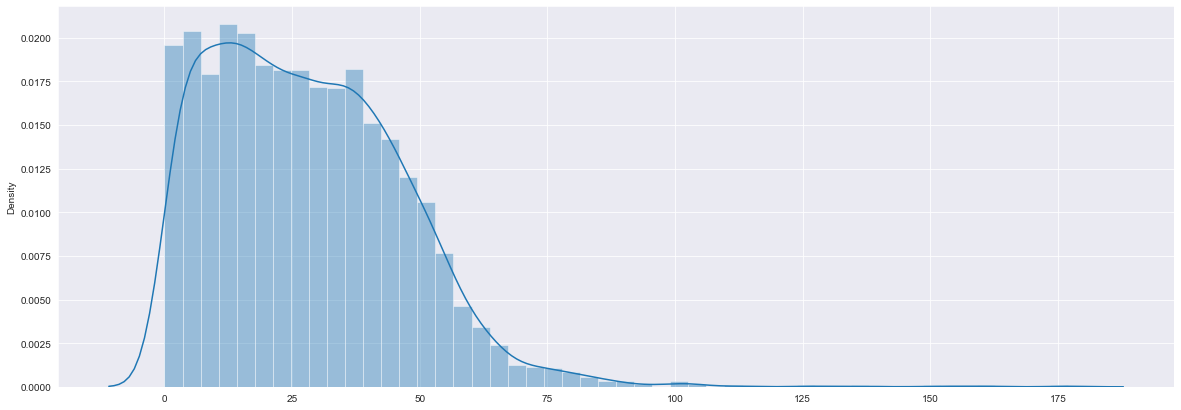

In [976]:
sns.distplot(abs(df.y_true - df.y_pred))
plt.show()

### Test Data(Unseen/Future Data)

In [977]:
Filepath = r'D:\Samarjit\Analytic Vidya\Job-a-thon\Data\test_6QvDdzb.csv'
test_df = pd.read_csv(Filepath,parse_dates=['date'])
test_df.head()

date  hour
0 2021-03-01     0
1 2021-03-01     1
2 2021-03-01     2
3 2021-03-01     3
4 2021-03-01     5

In [978]:
test_df.date.min(),test_df.date.max()

(Timestamp('2021-03-01 00:00:00'), Timestamp('2022-03-28 00:00:00'))

In [979]:
test_df.hour.min(),test_df.hour.max()

(0, 23)

In [980]:
test_df.shape

(7650, 2)

### Feature Engineering & Data Preparation

In [981]:
test_df['day'] = test_df.date.dt.day
test_df['month'] = test_df.date.dt.month
test_df['year'] = test_df.date.dt.year
test_df['weekday'] = test_df.date.dt.weekday

In [982]:
test_df['is_weekend'] = test_df.weekday.apply(lambda x: 'Yes' if x in [5,6] else 'No')

In [983]:
test_df.head()

date  hour  day  month  year  weekday is_weekend
0 2021-03-01     0    1      3  2021        0         No
1 2021-03-01     1    1      3  2021        0         No
2 2021-03-01     2    1      3  2021        0         No
3 2021-03-01     3    1      3  2021        0         No
4 2021-03-01     5    1      3  2021        0         No

In [984]:
def convertmonth(x):
  month = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December']
  monthnum = range(1,13,1)
  monthdict = dict()
  for v1,v2 in zip(monthnum,month):
    monthdict[v1] = v2
  
  return monthdict[x]

In [985]:
test_df.month = test_df.month.apply(lambda x: convertmonth(x))

In [986]:
test_df.year = test_df.year.apply(lambda x: str(x))
test_df.day = test_df.day.apply(lambda x: 'day_' + str(x))
test_df.is_weekend = test_df.is_weekend.apply(lambda x: 1 if x == 'Yes' else 0)

In [987]:
test_df = pd.get_dummies(test_df, \
                columns=['hour','weekday','is_weekend'])
test_df.head()

date    day  month  year  hour_0  hour_1  hour_2  hour_3  hour_4  \
0 2021-03-01  day_1  March  2021       1       0       0       0       0   
1 2021-03-01  day_1  March  2021       0       1       0       0       0   
2 2021-03-01  day_1  March  2021       0       0       1       0       0   
3 2021-03-01  day_1  March  2021       0       0       0       1       0   
4 2021-03-01  day_1  March  2021       0       0       0       0       0   

   hour_5  hour_6  hour_7  hour_8  hour_9  hour_10  hour_11  hour_12  hour_13  \
0       0       0       0       0       0        0        0        0        0   
1       0       0       0       0       0        0        0        0        0   
2       0       0       0       0       0        0        0        0        0   
3       0       0       0       0       0        0        0        0        0   
4       1       0       0       0       0        0        0        0        0   

   hour_14  hour_15  hour_16  hour_17  hour_18  hour_19  hour_20  hour_21  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   hour_22  hour_23  weekday_0  weekday_1  weekday_2  weekday_3  weekday_4  \
0        0        0          1          0          0          0          0   
1        0        0          1          0          0          0          0   
2        0        0          1          0          0          0          0   
3        0        0          1          0          0          0          0   
4        0        0          1          0          0          0          0   

   weekday_5  weekday_6  is_weekend_0  is_weekend_1  
0          0          0             1             0  
1          0          0             1             0  
2          0          0             1             0  
3          0          0             1             0  
4          0          0             1             0

In [988]:
test_df.drop(columns = 'date',inplace=True)

In [989]:
test_df.shape

(7650, 36)

In [990]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7650 entries, 0 to 7649
Data columns (total 36 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   day           7650 non-null   object
 1   month         7650 non-null   object
 2   year          7650 non-null   object
 3   hour_0        7650 non-null   uint8 
 4   hour_1        7650 non-null   uint8 
 5   hour_2        7650 non-null   uint8 
 6   hour_3        7650 non-null   uint8 
 7   hour_4        7650 non-null   uint8 
 8   hour_5        7650 non-null   uint8 
 9   hour_6        7650 non-null   uint8 
 10  hour_7        7650 non-null   uint8 
 11  hour_8        7650 non-null   uint8 
 12  hour_9        7650 non-null   uint8 
 13  hour_10       7650 non-null   uint8 
 14  hour_11       7650 non-null   uint8 
 15  hour_12       7650 non-null   uint8 
 16  hour_13       7650 non-null   uint8 
 17  hour_14       7650 non-null   uint8 
 18  hour_15       7650 non-null   uint8 
 19  hour_1

In [991]:
X_test_year_bow = CountVectorizer1.transform(test_df.year.values)
X_test_month_bow = CountVectorizer2.transform(test_df.month.values)
X_test_day_bow = CountVectorizer3.transform(test_df.day.values)

print(X_test_year_bow.shape)
print(X_test_month_bow.shape)
print(X_test_day_bow.shape)

(7650, 4)
(7650, 12)
(7650, 31)


In [992]:
sel_cols = [col for col in test_df.columns if col not in ['year', 'month','day','is_weekend']]

X_test = hstack((test_df[sel_cols],X_test_year_bow,X_test_month_bow,X_test_day_bow)).tocsr()

print(X_test.shape)

(7650, 80)


In [993]:
X_test = X_test.astype('float32')

In [994]:
y_test_pred = model.predict(X_test).astype(int)

In [995]:
y_test_pred[0:5]

array([[60],
       [60],
       [60],
       [60],
       [60]])

### Submission File - Merging Predicted Data on Submission File

In [996]:
Filepath = r'D:\Samarjit\Analytic Vidya\Job-a-thon\Data\sample_4E0BhPN.csv'
sub_df = pd.read_csv(Filepath,parse_dates=['date'])
sub_df.head()

date  hour  demand
0 2021-03-01     0       0
1 2021-03-01     1       0
2 2021-03-01     2       0
3 2021-03-01     3       0
4 2021-03-01     5       0

In [997]:
sub_df.shape

(7650, 3)

In [998]:
sub_df.demand = y_test_pred

In [999]:
sub_df.head()

date  hour  demand
0 2021-03-01     0      60
1 2021-03-01     1      60
2 2021-03-01     2      60
3 2021-03-01     3      60
4 2021-03-01     5      60

In [1000]:
sub_df.isnull().sum()

date      0
hour      0
demand    0
dtype: int64

In [1001]:
sub_df.to_csv('D:\Samarjit\Analytic Vidya\Job-a-thon\Data\sample_submission_2.csv',index=False)

- Best RMSE Score(On Future Data) - 34.4005657197